# Deep Probabilistice Generative Models - Variational Auto-Encoders

For this lab exercise, you have to use Pytorch.
If you don't know Pytorch or you don't know how to use it, please start by reading the following link:

- https://pytorch.org/tutorials/beginner/nlp/pytorch_tutorial.html

When you use Pytorch function, it is important to carefully read the documentation to understand how the different functions, what kind of transformation they apply etc.
Searching on stackoverflow is not enough. :) 
You have to take time to read it carefully to understand what you are doing.

- https://pytorch.org/docs/stable/torch.html
- https://pytorch.org/docs/stable/nn.html
- https://pytorch.org/docs/stable/nn.functional.html

The most import tip: keep track of the dimension of your tensor and what information they contain!

For examples, you can look at the GMM optimization via gradient descent notebook from the first course and at the MNIST classification example below. Don't just run them, try to understand them! Could you recode them from scratch without internet/example access?

# Members

- Leonardo Masci

- Benedictus Kent Rachmat

- Diego Torres Guarin

## 0. Preprocessing

Import the libraries we will use.
You can download the file dataset_loader from the course website.

In [28]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Next, we download and preprocess the MNIST dataset, see http://yann.lecun.com/exdb/mnist/ .
Our observed random variables will be Bernoulli distributions, so we need to binarize the dataset, i.e. each pixel can either be black or white.

In [30]:
# Download mnist dataset 
# if("mnist.pkl.gz" not in os.listdir(".")):
#     !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# the dataset contains 3 splits (train/dev/test),
# each one containing two vectors (pixels and classes)
(train_data_pixels, train_data_classes), \
(dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

In [31]:
# to binarize, we just set to 1 pixels with a value >= 0.5, 0 otherwise
train_data_pixels = 1*(train_data_pixels >= 0.5)
dev_data_pixels = 1*(dev_data_pixels >= 0.5)

In [32]:
# dataset_loader return numpy tensors,
# we convert them directly to pytorch tensors
train_data_pixels = torch.from_numpy(train_data_pixels).float()
train_data_classes = torch.from_numpy(train_data_classes).long()

dev_data_pixels = torch.from_numpy(dev_data_pixels).float()
dev_data_classes = torch.from_numpy(dev_data_classes).long()

In [33]:
# there 50000 images, each image is of size 28x28
# each image as been reshaped as vector of size 784
print("Shape of the pixel tensor:", train_data_pixels.shape)
print("Shape of the class tensor:", train_data_classes.shape)

Shape of the pixel tensor: torch.Size([50000, 784])
Shape of the class tensor: torch.Size([50000])


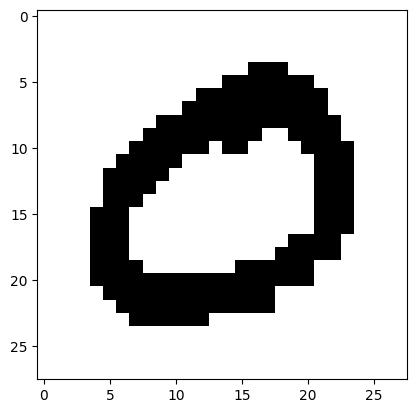

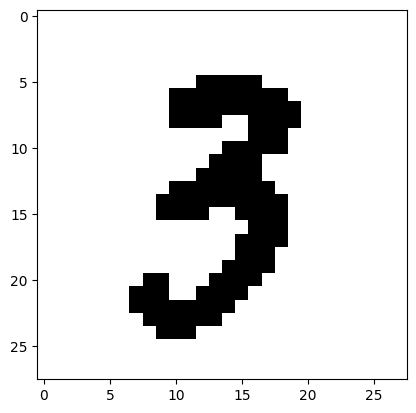

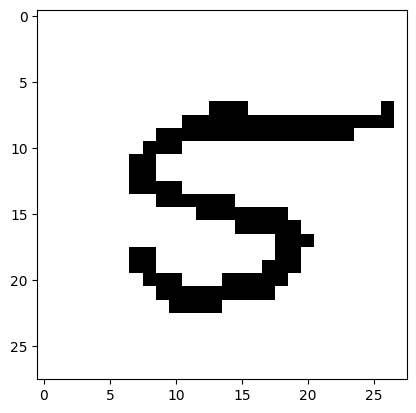

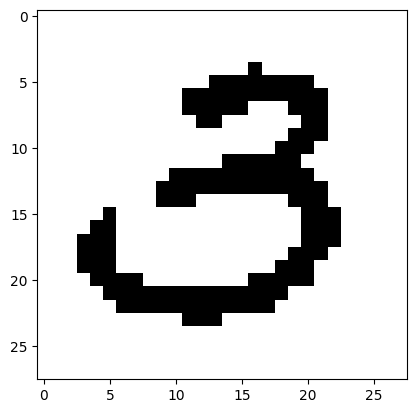

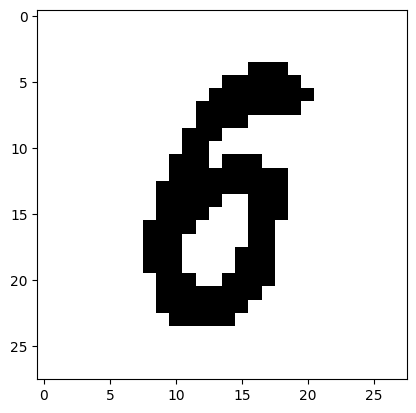

In [34]:
# we will use this function to print images generated by our network
# the parameter images must be a tensor of shape (n images, 784)
def display_images(images):
    # convert to numpy tensor
    images = images.detach().numpy()

    for i in range(images.shape[0]):
        plt.imshow(images[i].reshape(28,28), cmap='Greys')
        plt.show()
        
# display the 5 first image in the dataset
display_images(train_data_pixels[:5])

## 1. MNIST classification with Pytorch

In this first part, you need to study the code to understand how Pytorch works. :)
The example is a simple classifier for MNIST data.

**TODO**

- can you write mathematically the function computed by this network?
- what are the dimensions of each parameter?

It is very import that you are able to write that and understand what tensor operation it does.
This is the **root** of machine learning and especially deep learning.
To help you, draw the matrices/vectors!

In [35]:
# to create a neural network (or a part of a neural network),
# we create a class that extends nn.Module
class Classifier(nn.Module):
    # the constructor, parameters are self-documented by their name :)
    # input_dim: in our case it will the size of a single input image
    # hidden_dim: the hidden representation dim
    # output_dim: the number of class, in our case there are 10 digits
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_ratio=0.5):
        super().__init__()
        
        # we have two projections in the network,
        # the first one project the input in the hidden space,
        # the second one project the hidden representation in the output space.
        # have a look at the documentation of nn.Linear!
        # nn.Linear extends nn.Module
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        
        # dropout can be used to prevent overfitting,
        # however, it may be better to start training VAE without!
        # I just put it here for the example
        
        # let assume you create a network with:
        # network = Classifier(10, 10, 10)
        # then, to enable dropout you must call:
        # network.train()
        # and to disable dropout:
        # network.eval()
        # basically this calls set the network
        # in training and evaluation modes, respectively
        self.dropout = nn.Dropout(0.5)
        
    # this is the function that will be called
    # when we pass data to the network to compute the output
    # shape of batch: (n samples, output_dim)
    # where n samples is the number of samples in the batch
    def forward(self, batch):
        hid = self.proj1(batch)
        
        # non-linearity, it could have been a nn.Module object stored in this module,
        # here we use the functionnal version
        hid = F.relu(hid)
        
        # note: dropout is used to prevent overfitting
        hid = self.dropout(hid)
        
        # return the output, i.e. logits of each class for each sample in the batch
        # shape: (n samples, output_dim)
        return self.proj2(hid)

If we start from the flattend version of the image (the one present in the dataset), the whole processing done by the network can be decomposed in several operations

1. The first one is a matrix multiplication. For a given batch the dimensions are (batch_len, 784), when processed by the first layer, this tensor gets multiplied by a (784, hidden_dim) matrix, which results in a (batch_len, hidden_dim) tensor. As such, we are projecting the 784-dimensional feature vector onto a space with hidden_dim dimensions. In equations, if $X_{in}$ is the batch, the first hidden layer is given by:
$$
    X_{1} = X_{in}@W
$$

2. Non-linearity. We apply the ReLU activation function, which for an input vector $x_i$, gives as result the vector with the components 
$$
    v_i = max(0, x_i)
$$

3. Dropout regularization. With a probability of 50% we randomly mask some of the hidden units in the network. In this way, the model learns to use all the hidden units more evenly, instead of heavily relying on a small subset.

4. Finally, a matrix multiplication is used to project the hidden units onto the appropriate space. Its dimensions are (hidden_dim, 10), since we have 10 classes. Putting it all together:

$$
    X_{out} = \textrm{Dropout}(\textrm{ReLU}(X_{in}@W))@W_{out}
$$

In [69]:
n_epoch = 20
batch_size = 100

# build the network!
network = Classifier(28*28, 200, 10)

# optimizer that will be used to update the parameters!
optimizer = torch.optim.Adam(network.parameters())

all_epoch_losses = list()
all_epoch_accuracies = list()
for epoch in range(n_epoch):
    # we keep track of the loss at each epoch
    epoch_loss = 0
    
    # Note: one trick often used is to shuffle the data at each epoch,
    # we won't do that here.
    # if you want to do it, be carefull:
    # you need to shuffle both train_data_pixels and train_data_classes
    # so that they match, i.e. you cannot shuffle them independently!

    network.train() # set the network in train mode (i.e. enable dropout)
    
    # loop over the data
    for i in range(0, train_data_pixels.shape[0], batch_size):
        # IMPORTANT:
        # we must always call zero_grad() because each call to .backward()
        # will accumulate the gradient!
        optimizer.zero_grad()
        
        # batch of data
        # shape: (n samples, 784)
        # do you understand why n samples can be different of batch_size?
        batch = train_data_pixels[i:i+batch_size]
        
        # compute the weights associate with each class for each picture
        # logits shape: (n samples, 10)
        logits = network(batch)
        
        # compute the loss
        # look at the documentation of the function!
        loss = F.cross_entropy(
            logits,
            train_data_classes[i:i+batch_size],
            reduction="mean"
        )
        
        # to accumulate to the epoch loss,
        # we need to call loss.item() so the value
        # will detached from the computational graph,
        # i.e. loss.item() is python float, not a pytorch object.
        # can you understand why we multiply by batch_size.shape[0] ?
        epoch_loss += loss.item() * batch.shape[0]
        
        loss.backward() # compute the gradient
        optimizer.step() # update parameters of the model
        
    # at the end of each epoch, we eval on the dev data
    network.eval()
    n_dev_correct = 0
    
    # we don't need gradient computation during evaluation,
    # so we enclose computation with torch.no_grad(),
    # this will makes computation more efficient
    with torch.no_grad():
        for i in range(0, dev_data_pixels.shape[0], batch_size):
            batch = dev_data_pixels[i:i+batch_size]
            logits = network(batch)
            
            # compute the class of maximum weight for each sample,
            # look at the documentation of argmax!
            # pred shape: (n samples,)
            pred = logits.argmax(1)
            
            # compare prediction with gold classes
            n_dev_correct += (pred == dev_data_classes[i:i+batch_size]).sum().item()
    
    all_epoch_losses.append(epoch_loss)
    all_epoch_accuracies.append(n_dev_correct / dev_data_classes.shape[0]) 
    print(
        epoch, ":\t",
        epoch_loss,# / len(train_data[0]),
        "\t / dev precision:\t",
        n_dev_correct / dev_data_classes.shape[0],
        flush=True
    )

0 :	 24684.96119529009 	 / dev precision:	 0.9377
1 :	 12809.908846765757 	 / dev precision:	 0.9538
2 :	 9997.420174628496 	 / dev precision:	 0.961
3 :	 8463.8872474432 	 / dev precision:	 0.9652
4 :	 7364.450457692146 	 / dev precision:	 0.9677
5 :	 6564.183467626572 	 / dev precision:	 0.9694
6 :	 5929.7380816191435 	 / dev precision:	 0.9698
7 :	 5456.319784373045 	 / dev precision:	 0.9711
8 :	 4961.041393689811 	 / dev precision:	 0.972
9 :	 4682.619285210967 	 / dev precision:	 0.9723
10 :	 4392.13803075254 	 / dev precision:	 0.9739
11 :	 4094.6116687729955 	 / dev precision:	 0.9748
12 :	 3864.496303256601 	 / dev precision:	 0.9752
13 :	 3419.253130350262 	 / dev precision:	 0.9744
14 :	 3428.46619784832 	 / dev precision:	 0.9746
15 :	 3289.0328014735132 	 / dev precision:	 0.9754
16 :	 3063.744041416794 	 / dev precision:	 0.9751
17 :	 2965.1736196596175 	 / dev precision:	 0.9753
18 :	 2851.137273106724 	 / dev precision:	 0.9759
19 :	 2731.488215411082 	 / dev precision:

In [78]:
all_epoch_losses = np.array(all_epoch_losses) / len(train_data_pixels)

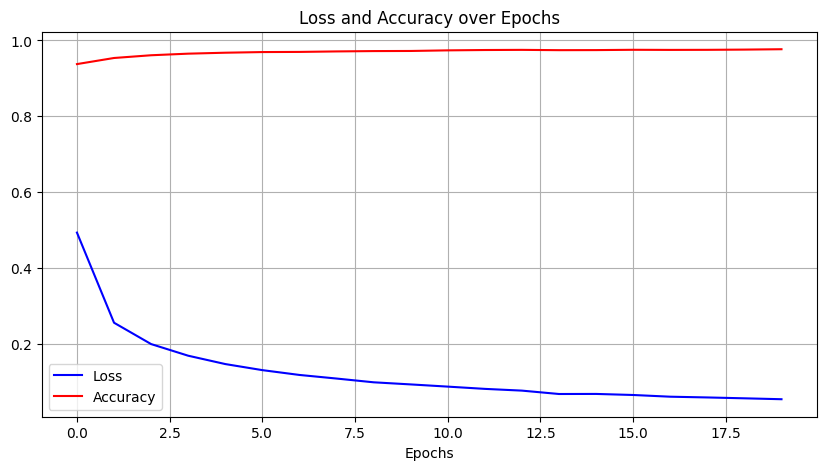

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n_epoch), all_epoch_losses, label='Loss', color='blue')
plt.plot(np.arange(n_epoch), all_epoch_accuracies, label='Accuracy', color='red')
plt.xlabel('Epochs')
plt.title('Loss and Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## 2. VAE with continuous latent space and binary observed space

The first VAE that we will develop is based on the following generative story:

1. $z \sim p(z)$
2. $x \sim p(x | z ; \theta)$

where the latent random variable $Z$ takes value in $\mathbb R^n$.
The prior ditribution $p(z)$ is a multivariate Gaussian where each coordinate is independent.
We fix the mean and variance of each coordinate to 0 and 1, respectively.
The conditional distribution $p(x | z ; \theta)$ is parameterized by a neural network.
The random variables $X$ are $m$ independent Bernoulli random variables.

Note: this kind of VAE will be quite bad at generating MNIST picture.
Therefore, when you do you experiments, you should both generate picture and show the distribution $p(x | z ; \theta)$ as a picture.
This is a well known problem of VAE, you can try to play with the network architecture and the parameters to improve generation.
However, hyperparameter optimization is not the goal of this lab exercise. :)
Another solution would be to use Gaussian random variables for the output distribution, but we won't do that here.

### KL divergence

The first function we have to implement is the one that compute the KL divergence with the prior.
You can find the formula in appendix B of the following paper: https://arxiv.org/pdf/1312.6114.pdf

**WARNING:** In the paper they give the formula for the -KL, and here we want the KL, so don't forget to put a minus sign in front of their formula. :)

In [38]:
# the shapes of mu and log_sigma_squared are: (n batch, n latent)
# the return vector must be of shape: (n batch,)
def KL_with_gaussian_prior(mu, log_sigma_squared):
    kl_divergence = -0.5 * torch.sum(1 + log_sigma_squared - mu.pow(2) - log_sigma_squared.exp(), axis=1, keepdim=True).squeeze()
    return kl_divergence
    
# test for shape
z_param = torch.rand((10, 30))
log_sigma_squared = torch.rand((10, 30))

if KL_with_gaussian_prior(z_param, log_sigma_squared).shape != (10, ):
    raise RuntimeError("Invalid return dim!")
else:
    print("return dim is ok.")
    
# test for return value
# result should be 0 as it is equal to the prior
print("Should be 0:", KL_with_gaussian_prior(torch.tensor([[0.]]), torch.tensor([[0.]])).item())
print("Should be 0.5:", KL_with_gaussian_prior(torch.tensor([[1.]]), torch.tensor([[0.]])).item())
print("Should be 2.6945...:", KL_with_gaussian_prior(torch.tensor([[1.]]), torch.tensor([[2.]])).item())

return dim is ok.
Should be 0: -0.0
Should be 0.5: 0.5
Should be 2.6945...: 2.694528102874756


### Network

Next you need to code the encoder and the decoder.
The encoder should return a tuple of tensors (mu, log_sigma_squared),
both are unconstrained so they should be the output of a linear projection.
The term log_sigma_squared means that the standard deviation can be computed via sigma=exp(0.5 * log_sigma_squared).
Be sure you understand this.

The structure of the encoder should be as follow:

- one projection and non linearity (e.g. relu) to compute a hidden representation of the input,
- two projections to compute my and log_sigma_squared from the same hidden representation.

The structure of the decoder shoud be similar to the classifier above.
Similarly to the encoder, the decoder should output unconstrained value, i.e. it does not directly return the mu parameters of the Bernoulli distribution, but values in R.
In your code, if you need to get the distribution, you can call sigmoid(mu) to transform the unconstrained values to the mu parameters.

- one projection and non linearity (e.g. relu) to compute a hidden representation of the input,
- one projection to the output space

The decode has two additional functions:

- sample_distributions: it samples from the prior and return the conditional output distributions (so here it means that you **must** apply the sigmoid befaire returning)
- sample_images: call sample_distributions and then sample images from the output distributions.

To sample from a Bernoulli you can use the following function: https://pytorch.org/docs/stable/generated/torch.bernoulli.html
To sample from the Gaussian prior, you can:

- first create an empty tensor via https://pytorch.org/docs/stable/generated/torch.empty.html
- then fill values in the tensor via https://pytorch.org/docs/stable/tensors.html#torch.Tensor.normal_

This second function change a tensor in-place (hence the _ at the end of the name)

In [39]:
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.mu_proj = nn.Linear(hidden_dim, output_dim)
        self.log_sigma_squared_proj = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        
        mu = self.mu_proj(hid)
        log_sigma_squared = self.log_sigma_squared_proj(hid)
        
        return mu, log_sigma_squared

In [40]:
class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        
        return self.proj2(hid)
    
    # n_samples: number of "image output distribution" to compute
    def sample_distributions(self, n_samples):
        # first you must sample from the prior,
        # then you must pass the data through this network, i.e. self(z)
        
        # shape of z: (n_samples, input_dim)
        z = torch.normal(0, 1., (n_samples, self.input_dim)).to(device)
        
        return torch.sigmoid(self(z))
        
    
    # sample images
    def sample_images(self, n_samples, argmax=False):
        # compute the output distributions for each image
        # probs shae: (n_samples, output_dim)
        probs = self.sample_distributions(n_samples)
        
        # then sample output pixels
        # there are two modes:
        # argmax=False: sample from the output distribution
        # argmax=True: instead of sampling, return the most probable value for each random variable
        # (check how the images are converted to binary images above!)
   
        if not argmax:
            return torch.bernoulli(probs)
        
        else:
            return (probs >= 0.5).float()

### Training loop

I did most of the work, you just need to implement ont thing: the reparameterization trick! :)

In [41]:
dim_input = 28*28
latent_dim = 2 # we use only 2 dimensions so we can plot them!
hidden_dim = 400
n_epoch = 20
batch_dim = 256

encoder = GaussianEncoder(dim_input, hidden_dim, latent_dim).to(device)
decoder = GaussianPriorDecoder(latent_dim, hidden_dim, dim_input).to(device)

# we must pass both network parameters to the optimizer
# sometime its also useful to use two different optimizers,
# for example if we want to use different learning rates.
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data_pixels[i:i+batch_dim].to(device)
        
        # compute parameters of the approximate posterior
        z_param, log_sigma_squared = encoder(batch)
        
        # for MC sampling of the reconstruction loss,
        # we use one sample from the approximate posterior.
        # you need to use the reparameterization trick for this!
        # in order to sample from the the N(0, 1) distribution,
        # you can use:
        # torch.empty_like(mu).normal_(mean=0.,std=1.)
        # (check the documentation if you don't understand this!)
        

        epsilon = torch.normal(0, 1., z_param.shape, device=device)
        
        z = z_param + torch.exp(log_sigma_squared/2) * epsilon
        
        # reconstruction_logits: (batches, classes, output size)
        # note that the output of the network is in R,
        # to get Bernoulli parameters you must use the sigmoid.
        # For the reconstruction loss, you can either use:
        # - F.binary_cross_entropy_with_logits
        # - F.entropy_with_logits
        # Read the doc in order to understand the difference!
        # Warning: use the reduction="none" parameter
        rec_logits = decoder(z)
        rec_loss = F.binary_cross_entropy_with_logits(
            rec_logits,
            batch,
            reduction="none"
        )
        
        kl_div = KL_with_gaussian_prior(z_param, log_sigma_squared)
        
        # loss shape: (batch dim,)
        # do you understand why we sum along this dimension only?
        # there is a minus sign before reconstruction because
        # the loss formula is -log etc, but in the elbo its +log
        elbo = -rec_loss.sum(1) - kl_div
        
        epoch_reconstruction += -rec_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        # we want to maximize the ELBO,
        # but Pytorch does minimization,
        # so we define our loss as -ELBO
        # and we mean over instances in the dataset
        loss = -elbo.mean()
        loss.backward()
        
        # optimization trick :)
        # gradient clipping, so we don't take too big updates
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        optimizer.step()
        
    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0]
    )

0 :	 -194.95416009765626 	 5.631420184316635
1 :	 -162.4849969140625 	 5.00816975402832
2 :	 -157.33733701171874 	 5.26414336730957
3 :	 -154.968703359375 	 5.378858798828125
4 :	 -153.272135625 	 5.451891903686524
5 :	 -151.91290236328126 	 5.5156688427734375
6 :	 -150.7522075 	 5.583436572875977
7 :	 -149.68150732421876 	 5.63435683959961
8 :	 -148.68201892578125 	 5.7129871130371095
9 :	 -147.8339968359375 	 5.766109899902344
10 :	 -147.0025444921875 	 5.7967491918945315
11 :	 -146.242987890625 	 5.829863116455078
12 :	 -145.626532734375 	 5.878848709716797
13 :	 -144.9878915234375 	 5.924659423828125
14 :	 -144.4103000390625 	 5.951235951538086
15 :	 -143.905841953125 	 5.9825095739746095
16 :	 -143.3364357421875 	 6.009959334106445
17 :	 -142.88473138671876 	 6.019424385375976
18 :	 -142.46130509765624 	 6.061043665771485
19 :	 -142.063930859375 	 6.078069310913086


We can now visualize the output distribution from random prior samples and generate new images.

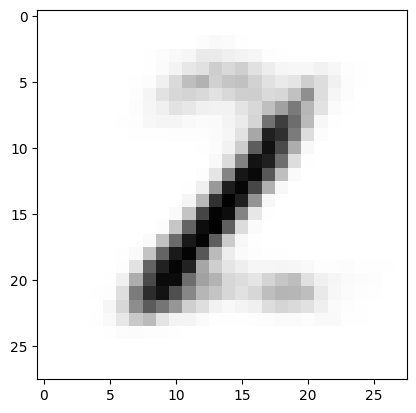

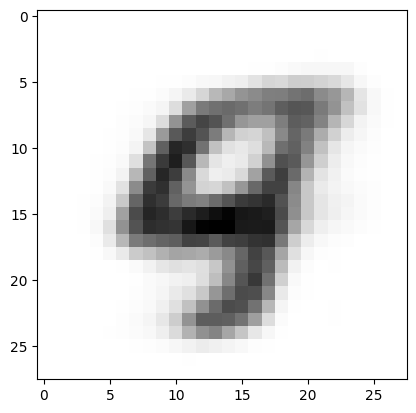

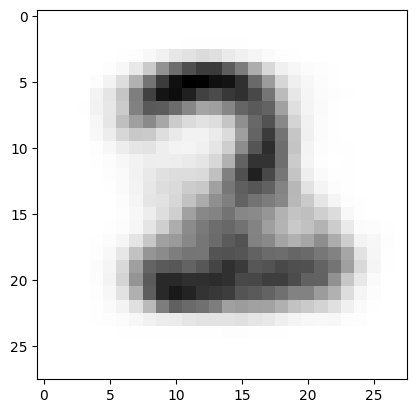

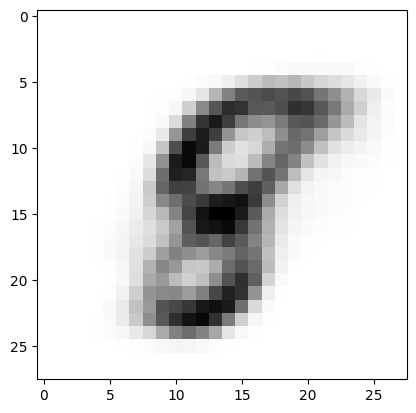

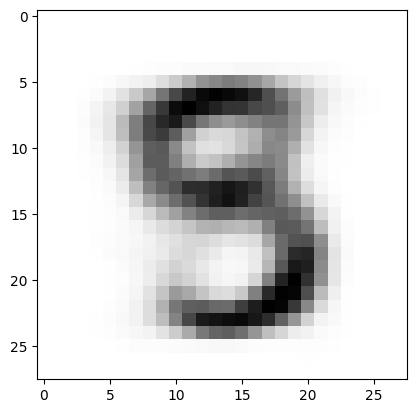

In [42]:
decoder.eval()

with torch.no_grad():
    # you can try true samples
    # or useing argmax
    samples = decoder.sample_distributions(5)
    samples = samples.cpu()
    display_images(samples)

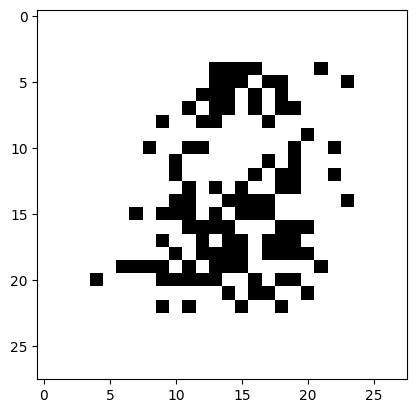

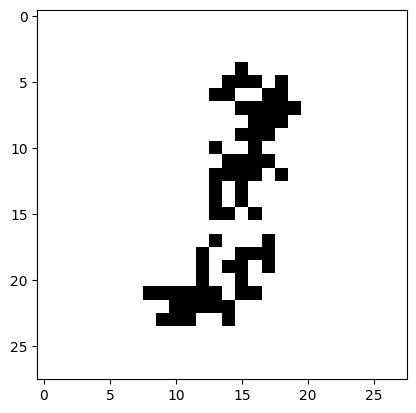

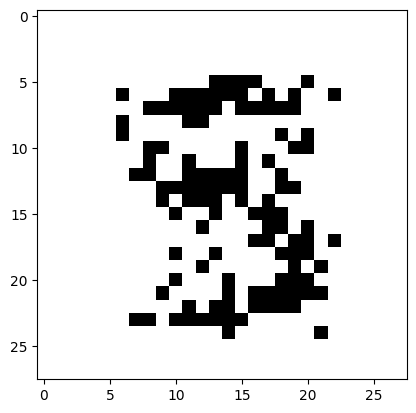

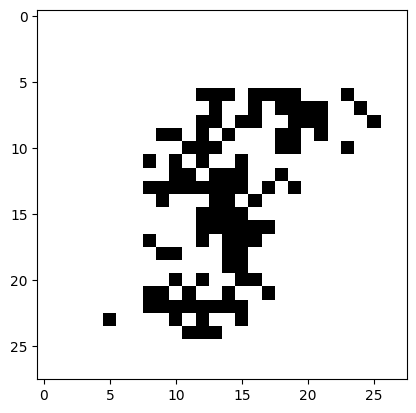

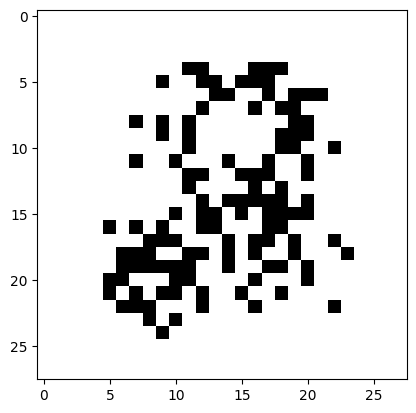

In [43]:
decoder.eval()

with torch.no_grad():
    # you can try true samples
    # or useing argmax
    samples = decoder.sample_images(5, argmax=False)
    samples = samples.cpu()
    display_images(samples)

Using the approximate posterior, we can visualize the latent space, by assigning one color per digit.
What we display is the mean value.
For a well trained model, we should see all points close to 0 and each class should be well delimited, i.e. there must be clusters of the same color.

If your samples and latent space are ugly, you could try to improve your model by:

- change the learning hyperparameters
- add/remove dropout
- change the network structure (number and size of layers, dropout...)

Note that if you want to visualize a latent space when its dimension is greater than two, you could project it in 2 dimensions using PCA (its already implemented in scikit-learn!)

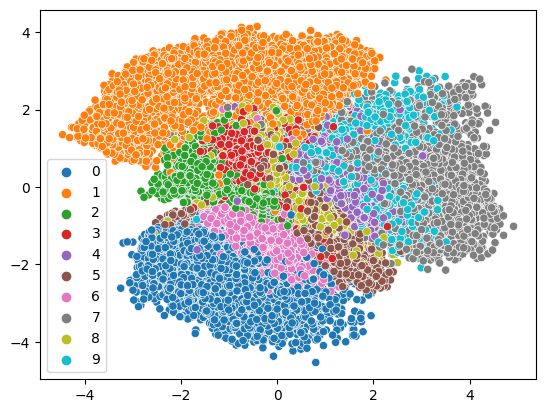

In [44]:
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim].to(device)
        z_param, _ = encoder(batch)
        points[i:i+batch_dim] = z_param.cpu().detach().numpy()

sns.scatterplot(
    x=points[:,0], y=points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    # https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
    hue=train_data_classes,
    palette="tab10"
)
plt.show()

## 3. VAE with binary latent space and binary observed space

The second VAE that we will develop is based on the same generative story:

1. $z \sim p(z)$
2. $x \sim p(x | z ; \theta)$

but where the latent variable $Z$ are independent Bernoulli random variables.
See the last video from the course to understand how this change the model.

### Architecture

How many values should the encoder return? What is the difference with the previous encoder?

In [45]:
class BernoulliEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        
        return torch.sigmoid(self.proj2(hid))

In [46]:
class BernoulliPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        
        return self.proj2(hid)
    
    def sample_distributions(self, n_samples):
        z = torch.bernoulli(0.5 * torch.ones((n_samples, self.input_dim))).to(device)
        
        return torch.sigmoid(self(z))
    
    def sample_images(self, n_samples, argmax=False):
        
        probs = self.sample_distributions(n_samples)
        
        if not argmax:
            return torch.bernoulli(probs)
        
        else:
            return (probs >= 0.5).float()

### KL divergence

We assume the prior are Bernoullis with parameter 0.5, i.e. the probability to sample 0 or 1 are equals ("fait coin" probability).
What the formula of the KL divergence? How does it simplify?

Hint: you should see an entropy term in it that you can compute via https://pytorch.org/docs/stable/distributions.html#torch.distributions.bernoulli.Bernoulli.entropy

In [47]:
# the shapes of mu and log_sigma_squared are: (n batch, n latent)
# the return vector must be of shape: (n batch,)
import math

def KL_with_bernoulli_prior(probs):
    n_latent = probs.shape[1]
    expression = -torch.distributions.Bernoulli(probs).entropy()
    return torch.sum(expression, axis=1) + n_latent * math.log(2)
    
# test for shape
probs = torch.rand((10, 30))

if KL_with_bernoulli_prior(probs).shape != (10, ):
    raise RuntimeError("Invalid return dim!")
else:
    print("return dim is ok.")
    
# test for return value
# result should be 0 as it is equal to the prior
print("Should be 0:", KL_with_bernoulli_prior(torch.tensor([[0.5, 0.5]])).item())
print("Should be 0.693...:", KL_with_bernoulli_prior(torch.tensor([[1.]])).item())

return dim is ok.
Should be 0: 0.0
Should be 0.693...: 0.6931470632553101


### Training loop

This time I let you on your own! :) 
Remember that you need to use the Score Function Estimator trick! (see the last video of the course)

You need to use a baseline to stabilize the variance of the estimator.
Here, we will rely on the average reconstruction value from all previous update.
You can easily store it and compute it using the running average trick:

In [48]:
n1 = 5
n2 = 10
n3 = 1
n4 = 12

print((n1 + n2 + n3 + n4) / 4)

running_average = 0

# after the first parameter update
n_updates = 1
running_average += (n1 - running_average) / n_updates

# after the second parameter update
n_updates += 1
running_average += (n2 - running_average) / n_updates

# etc etc
n_updates += 1
running_average += (n3 - running_average) / n_updates

n_updates += 1
running_average += (n4 - running_average) / n_updates

# should be equal to the previous printed value!
print(running_average)

7.0
7.0


In [49]:
dim_input = 28*28
latent = 64
hidden_dim = 400
n_epoch = 50
batch_dim = 256

encoder = BernoulliEncoder(dim_input, hidden_dim, latent).to(device)
decoder = BernoulliPriorDecoder(latent, hidden_dim, dim_input).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

running_avg = 0  # to control the variance of the SFE
n_updates = 0
for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0
    
    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data_pixels[i:i+batch_dim].to(device)
        
        output = encoder(batch)
        z_param = F.sigmoid(output)
        z = torch.bernoulli(z_param).detach()
        
        rec_logits = decoder(z)
        rec_loss = F.binary_cross_entropy_with_logits(
            rec_logits,
            batch,
            reduction="none"
        ).sum(1)
        
        kl_div = KL_with_bernoulli_prior(z_param)
        elbo = - rec_loss - kl_div
        
        log_prob_p = rec_loss - running_avg
        log_prob_q = - F.binary_cross_entropy_with_logits(output, z, reduction="none").sum(1)
        cross_loss = log_prob_p.detach() * log_prob_q - (log_prob_p * log_prob_q).detach()

        loss = (- elbo + cross_loss).mean()
        loss.backward()

        epoch_reconstruction += rec_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        optimizer.step()
        n_updates += 1
        with torch.no_grad():
            running_avg += (rec_loss.mean().item() - running_avg) / n_updates

        
    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0],
    )

0 :	 221.6982216796875 	 1.4401463545227051
1 :	 202.29294296875 	 1.268281909942627
2 :	 198.0143935546875 	 1.8146029205322265
3 :	 194.7563441015625 	 2.2710396490478515
4 :	 193.450698046875 	 2.3680093197631837
5 :	 192.692362109375 	 2.4523062817382812
6 :	 192.05307890625 	 2.4294273666381834
7 :	 191.3835078515625 	 2.4412223208618165
8 :	 190.423920234375 	 2.5922179602050783
9 :	 189.669610390625 	 2.626203505859375
10 :	 189.3923890625 	 2.6787477734375
11 :	 189.2627021875 	 2.650397922363281
12 :	 189.0108751171875 	 2.7501585946655274
13 :	 188.7686794921875 	 2.777747969665527
14 :	 188.693466875 	 2.7502855657958984
15 :	 188.29997216796875 	 2.769928994140625
16 :	 188.47570634765626 	 2.7192243661499025
17 :	 188.2051586328125 	 2.758460965270996
18 :	 188.279073203125 	 2.7638500650024413
19 :	 188.33765455078125 	 2.7288792401123048
20 :	 188.1618622265625 	 2.764406488342285
21 :	 187.71152994140624 	 2.7984558160400392
22 :	 187.7632971875 	 2.873325399169922
23 :

We can now visualize the trained model. :) 

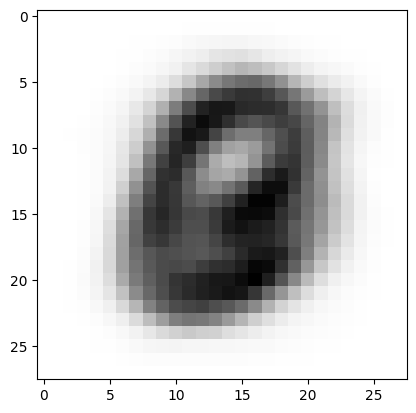

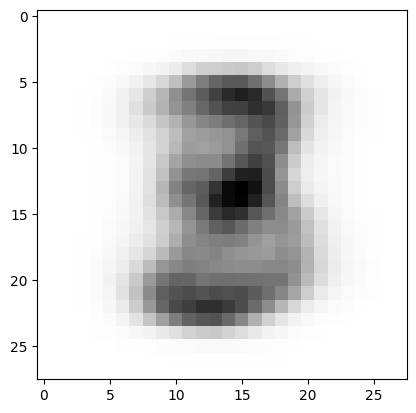

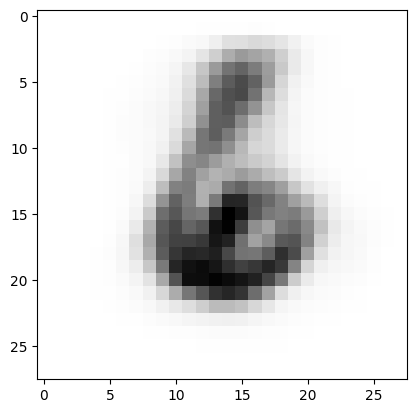

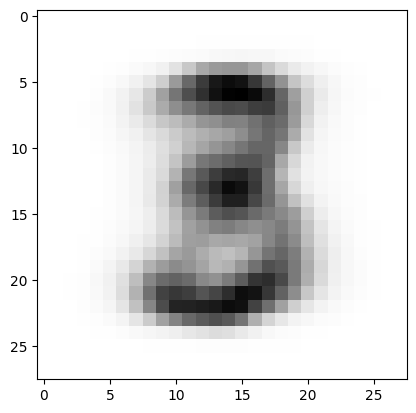

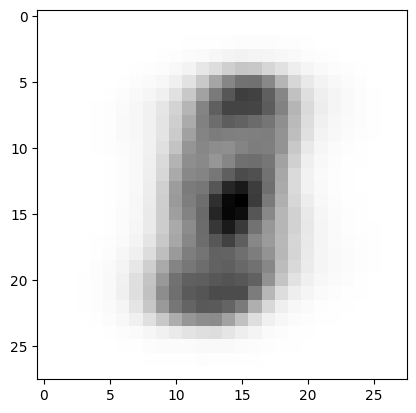

In [50]:
decoder.eval()

with torch.no_grad():
    samples = decoder.sample_distributions(5)
    samples = samples.to('cpu')
    display_images(samples)

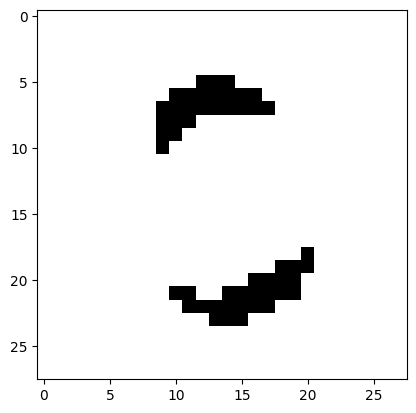

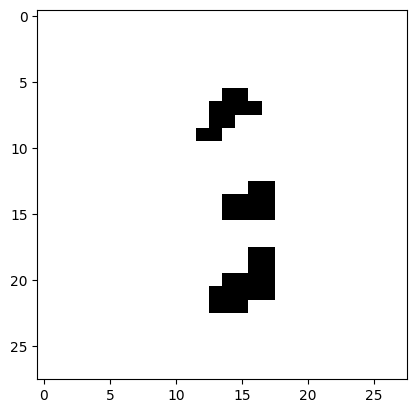

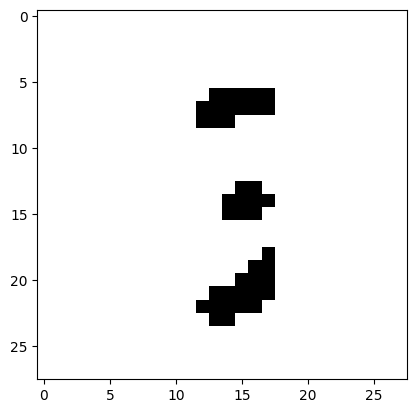

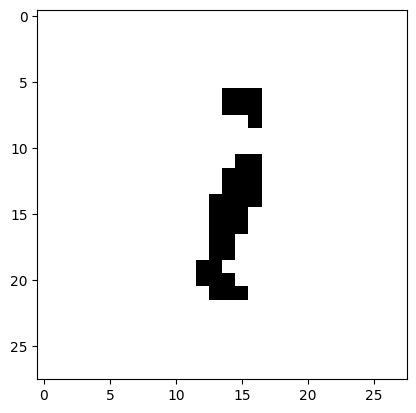

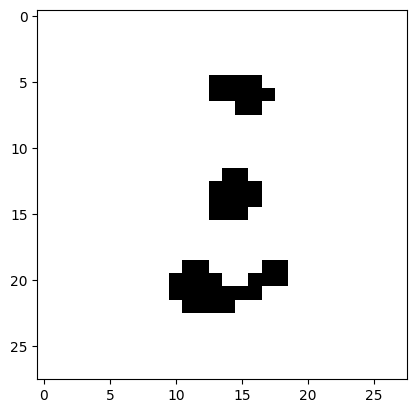

In [51]:
decoder.eval()

with torch.no_grad():
    # you can try true samples
    # or useing argmax
    samples = decoder.sample_images(5, argmax=True)
    samples = samples.to('cpu')
    display_images(samples)

# 4. Turning a Deterministic Auto-Encoder into a generative model


Last exercise!
Here I want to show you a trick to turn a deterministic model into a probabilistic generative model.
This a two step process.

First, you train an auto-encoder - not a VAE, just an encoder.
The encoder takes an image and project it in the latent space, here we will use a 2 dimension latent space.
It is a deterministic computation: the output of the encoder **is not** the parameters of the approximate posterior $q(z|x)$ distribution, it is a point in the $\mathbb R^2$ space.
The decoder reconstruct the input image from the encoder output.
Therefore, during training, the main difference is that you don't have a KL divergence term! :)

Second, we turn this deterministic model into a probabilistic generative model.
To do this, we look at where each training image of the training is mapped in the latent space.
You can train a Gaussian Mixture Model that will generate data that look like the latent space of the training set!
Then, to generate a new data point, you can:

1. sample a cluster from the GMM: $y \sim p(y)$
2. sample a point from the bivariate Gaussian associated with this cluster: $z \sim p(z|y)$
3. use the decoder to sample an image: $x \sim p(x | z)$

To fit and sample from the GMM, use the scikit learn library!
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

### Architecture and training loop of the auto-encoder

In [52]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        return self.proj2(hid)

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        
        return self.proj2(hid)

In [53]:
encoder = Encoder(784, 100, 2).to(device)
decoder = Decoder(2, 100, 784).to(device)

In [54]:
dim_input = 28*28
latent = 2
hidden_dim = 400
n_epoch = 50
batch_dim = 256

encoder = Encoder(dim_input, hidden_dim, latent).to(device)
decoder = Decoder(latent, hidden_dim, dim_input).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

n_updates = 0
for epoch in range(n_epoch):

    decoder.train()
    encoder.train()

    epoch_loss = 0
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data_pixels[i:i+batch_dim].to(device)
        
        latent = encoder(batch)
        output = decoder(latent)

        
        rec_loss = F.binary_cross_entropy_with_logits(
            output,
            batch,
            reduction="none"
        ).sum(1)
        
        loss = rec_loss.mean()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()*batch.shape[0]/train_data_pixels.shape[0]
        
    print(
        epoch, ":\t",
        epoch_loss
    )

0 :	 196.5903002539062
1 :	 167.4079472167968
2 :	 160.59995517578128
3 :	 156.88811198730468
4 :	 154.48178821289076
5 :	 152.63460567382813
6 :	 151.11280630371084
7 :	 149.83965505371094
8 :	 148.7244062207031
9 :	 147.7654801220704
10 :	 146.92605988769523
11 :	 146.22830813476563
12 :	 145.63387644531258
13 :	 145.13011320800788
14 :	 144.53189830566401
15 :	 143.91231524414064
16 :	 143.33610996582033
17 :	 142.8115314453126
18 :	 142.31253732421882
19 :	 141.8510066113281
20 :	 141.42725656738287
21 :	 141.02450589843747
22 :	 140.6654891162109
23 :	 140.35433565429693
24 :	 140.13929593750004
25 :	 140.0906447216797
26 :	 140.0187195117187
27 :	 139.55924364746096
28 :	 139.1584104736328
29 :	 138.8118842236328
30 :	 138.49825284667972
31 :	 138.18832211914057
32 :	 137.95068947265617
33 :	 137.7348665380858
34 :	 137.59672481445315
35 :	 137.64203148925776
36 :	 137.65519969726563
37 :	 137.24364895996098
38 :	 136.81504403320312
39 :	 136.51738234863265
40 :	 136.276366108398

In [55]:
with torch.no_grad():
    latent = encoder(train_data_pixels.to(device))
latent = latent.cpu().numpy()

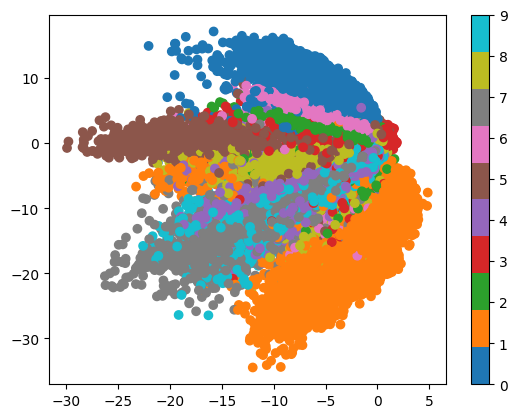

In [56]:
plt.scatter(latent[:, 0], latent[:, 1], c=train_data_classes, cmap='tab10')
plt.colorbar()

In [57]:
with torch.no_grad():
    reconstructed = torch.sigmoid(decoder(encoder(train_data_pixels[0].to(device))))

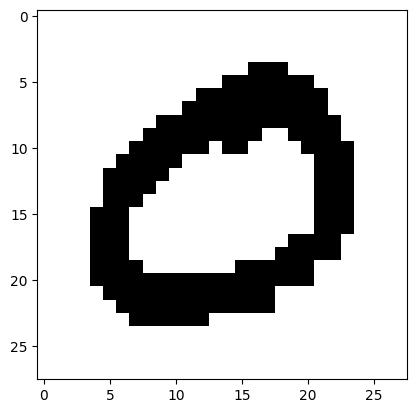

In [58]:
plt.imshow(train_data_pixels[0].numpy().reshape(28, 28), cmap='Greys')

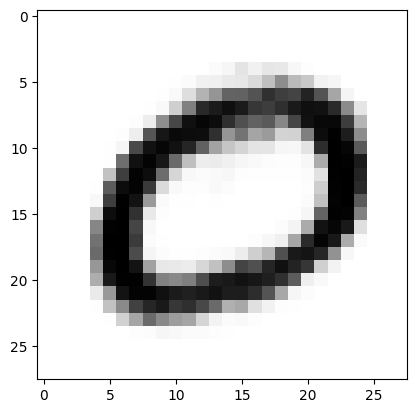

In [59]:
plt.imshow(reconstructed.cpu().numpy().reshape(28, 28), cmap='Greys')

In [60]:
from sklearn.mixture import GaussianMixture

In [87]:
gmm = GaussianMixture(n_components=10).fit(latent)

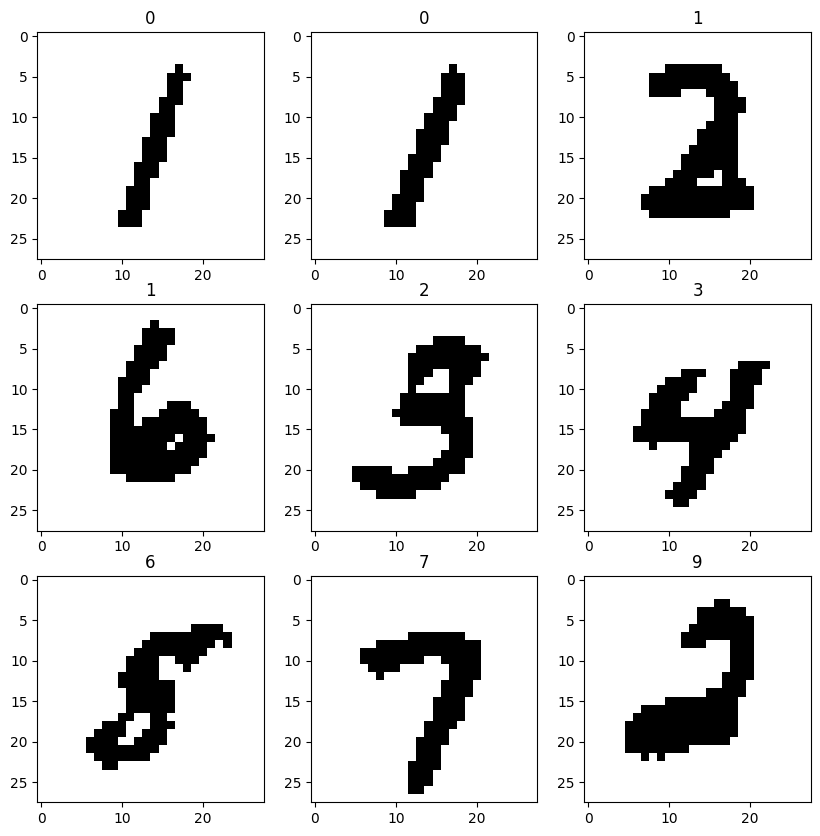

In [88]:
point, label = gmm.sample(9)

with torch.no_grad():
    generated = torch.sigmoid(decoder(torch.tensor(point, device=device).float())).cpu().numpy()
    generated = np.where(generated > 0.4, 1, 0)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated[i].reshape(28, 28), cmap='Greys')
    ax.set_title(label[i])

In [89]:
samples, _ = gmm.sample(60000)

[]

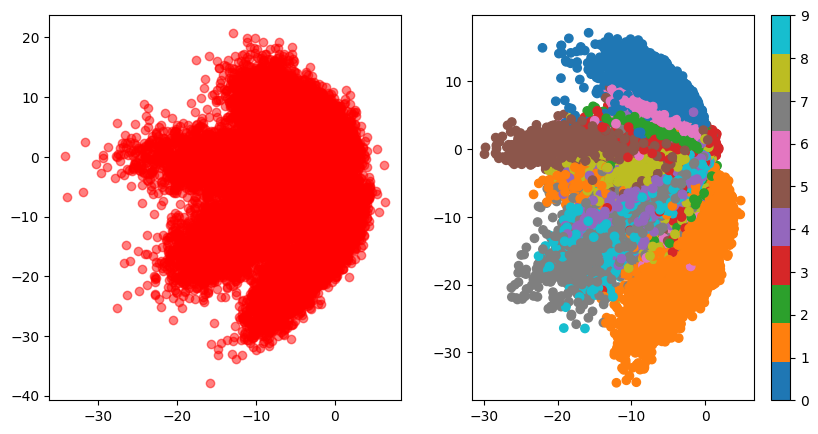

In [90]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(samples[:, 0], samples[:, 1], c='r', alpha=0.5)

plt.subplot(1, 2, 2)
plt.scatter(latent[:, 0], latent[:, 1], c=train_data_classes, cmap='tab10')
plt.colorbar()
plt.plot()

We can now visualize the latent space of the deterministic auto-encoder. How does it look like compared to the VAE one? Does it looks like we can fit it with a GMM?

### Turning the deterministic auto-encoder into a generative model

Todo:

1. fit the point from the encoder with a GMM (for example with 20 clusters, called components in scikit-learn): https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
2. Sample many points from this GMM and plot them: does the resulting point cloud looks like the one above? (or, in other words, did the GMM correctly fit the latent space?)
3. Sample new data from the model! How does it looks like compared to VAE? how does the output distribution looks like? Does it work?

Note: its an **unsupervised problem**, do not use class information in this part!

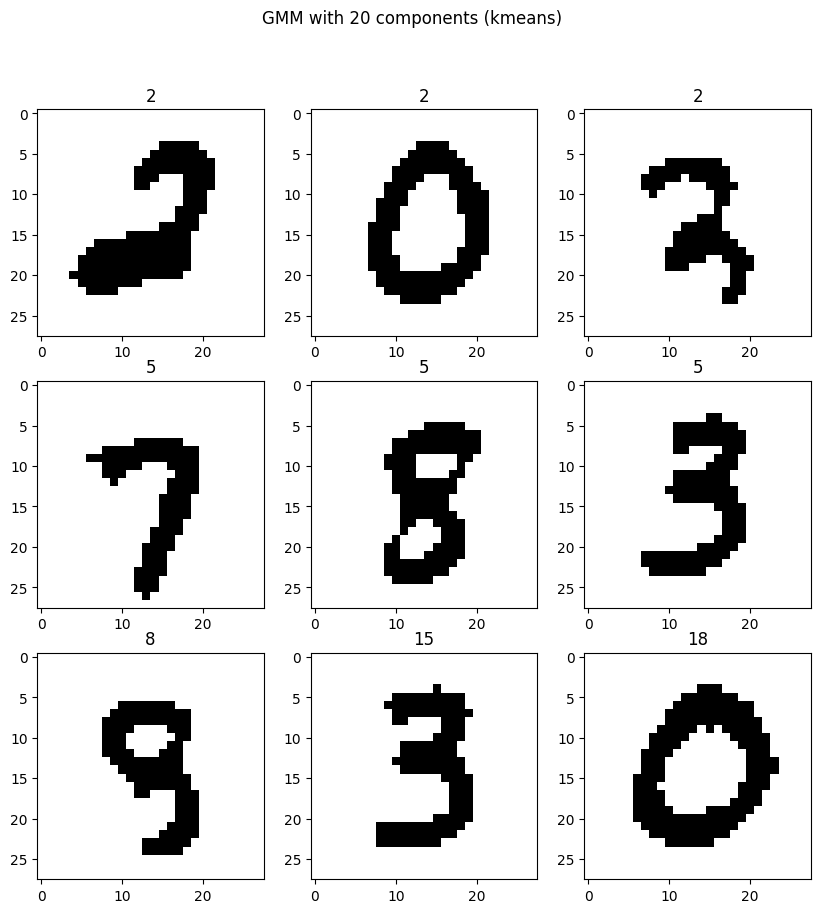

In [103]:
gmm = GaussianMixture(n_components=20).fit(latent)
point, label = gmm.sample(9)

with torch.no_grad():
    generated = torch.sigmoid(decoder(torch.tensor(point, device=device).float())).cpu().numpy()
    generated = np.where(generated > 0.4, 1, 0)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.suptitle('GMM with 20 components (kmeans)')

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated[i].reshape(28, 28), cmap='Greys')
    ax.set_title(label[i])

[]

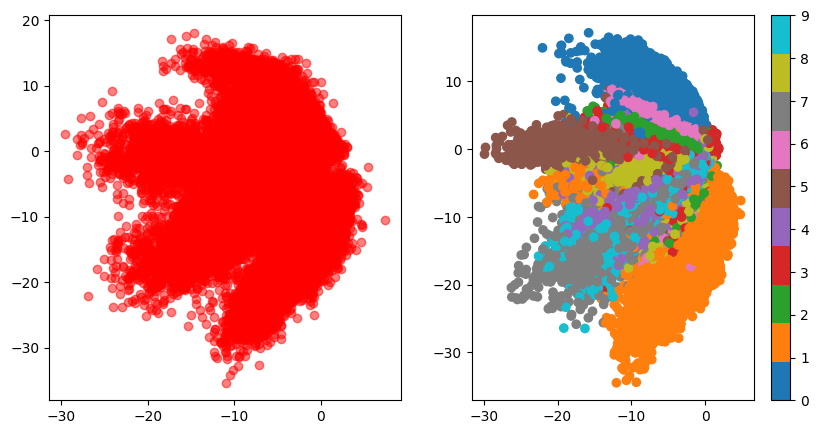

In [104]:
samples, _ = gmm.sample(60000)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(samples[:, 0], samples[:, 1], c='r', alpha=0.5)

plt.subplot(1, 2, 2)
plt.scatter(latent[:, 0], latent[:, 1], c=train_data_classes, cmap='tab10')
plt.colorbar()
plt.plot()

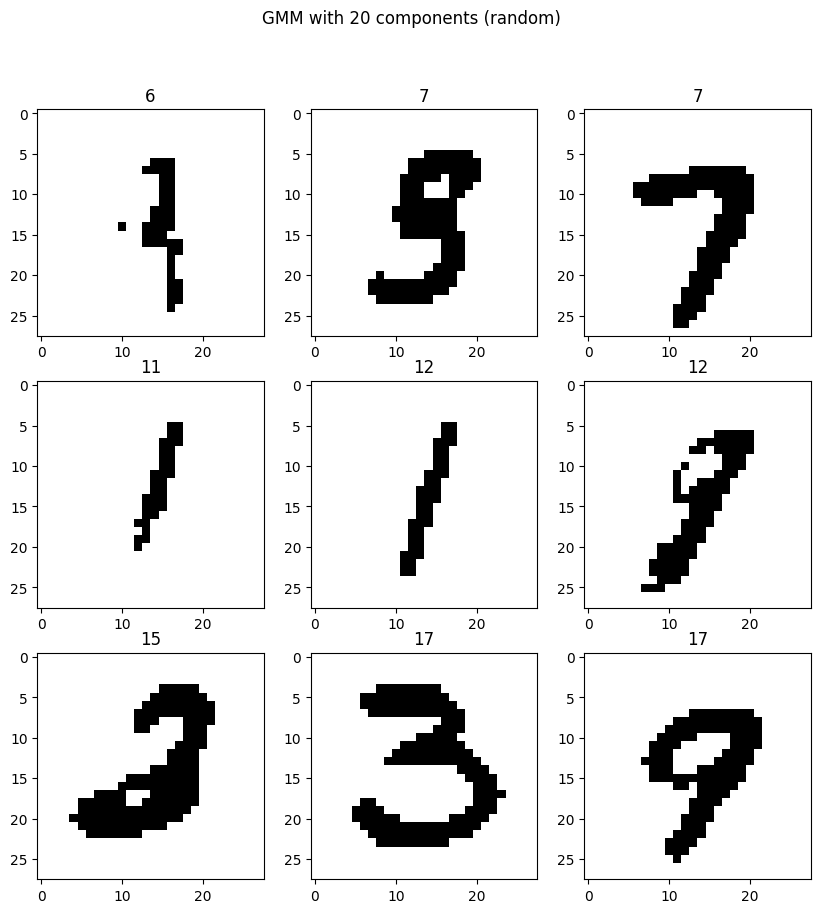

In [105]:
gmm = GaussianMixture(n_components=20, init_params="random").fit(latent)
point, label = gmm.sample(9)

with torch.no_grad():
    generated = torch.sigmoid(decoder(torch.tensor(point, device=device).float())).cpu().numpy()
    generated = np.where(generated > 0.4, 1, 0)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.suptitle('GMM with 20 components (random)')

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated[i].reshape(28, 28), cmap='Greys')
    ax.set_title(label[i])

[]

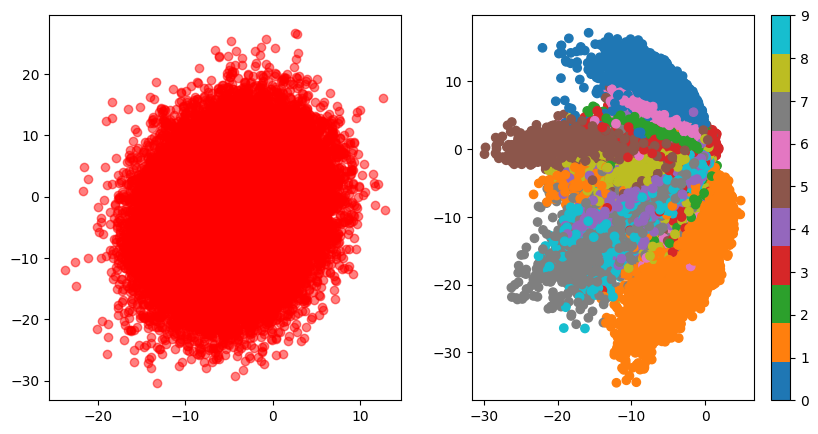

In [106]:
samples, _ = gmm.sample(60000)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(samples[:, 0], samples[:, 1], c='r', alpha=0.5)

plt.subplot(1, 2, 2)
plt.scatter(latent[:, 0], latent[:, 1], c=train_data_classes, cmap='tab10')
plt.colorbar()
plt.plot()

## Questions


1. Describe the MNIST database

The MNIST database is a widely-used dataset containing 70,000 handwritten digit images, split into 60,000 training and 10,000 testing samples. Each image is grayscale, 28x28 pixels in size, representing a digit from 0 to 9. This database is one of the benchmark in Computer Vision and it's widely used as an introduction to classification problem.


2. Introduce Variational Auto Encoder

Variational Autoencoders (VAEs) are a type of autoencoder that introduce probabilistic encoding and decoding. Unlike traditional autoencoders, which produce a single output for the encoded input, VAEs produce a distribution. The loss function for VAEs comprises two parts: the reconstruction loss (like standard autoencoders) and the KL-divergence, which measures the difference between the learned encoding distribution and a prior distribution. The formula for the VAE loss is:
$$
Loss=Reconstruction Loss+KL Divergence
$$

3. Describe Gaussian Mixture Model

A Gaussian Mixture Model (GMM) is a probabilistic model that assumes that the data is generated from a mixture of several Gaussian distributions. Each of these Gaussian distributions is characterized by its mean and variance. The goal of GMM is to find the parameters (means, variances, and mixture weights) that best fit the data. Mathematically, if we have $ K $ Gaussian distributions, the probability of a data point $ x $ is:

$$ p(x) = \sum_{k=1}^{K} w_k \mathcal{N}(x|\mu_k, \sigma_k^2) $$

where $ w_k $ is the weight, and $ \mathcal{N} $ is the Gaussian distribution with mean $ \mu_k $ and variance $ \sigma_k^2 $.

4. Experiment different initialization of GNN with K-means VS Random 

We can see in the scatter plot captures the underlying structure or density of our clustered data. The K-means tries to minimize the within-cluster variance, so its centroids will be positioned in regions of higher data density. In contrast, random initialization doesn't take data distribution into account. We can see a circular shaped plot  indicating that the GMM is starting with a generic, non-informative guess about the data distribution, which might or might not be refined effectively during subsequent training iterations.